In [7]:
import numpy as np
from scipy.stats import norm
import warnings
import matplotlib.pyplot as plt

# Convertir los warnings en excepciones
warnings.filterwarnings("error", category=RuntimeWarning)

## Auxiliar code to generate inverse normal CDF interpolation nodes 

In [8]:
epsilon = np.finfo(float).eps
print(f"Máquina epsilon: {epsilon}")

Máquina epsilon: 2.220446049250313e-16


In [81]:
def node_is_relevant(x_l, y_l, x_r, y_r, x, y, tolerance):
    y_interp = (x - x_l)/(x_r-x_l)*y_r + (x_r - x)/(x_r-x_l)*y_l
    error = np.abs(y_interp - y) / np.maximum(y_interp, y)
    return tolerance < error
    
# Lets reduce a bit the complexity
# As we are about to interpolate, we will remove the nodes for which the information is equivalent to interpolating
def compress(x, y, tolerance):
    length = len(x)
    relevances = np.ones(shape=(length,), dtype=bool)
    for index_l in range(length-2):
        if relevances[index_l]:
            index = index_l + 1
            index_r = index + 1
            try:
                relevances[index] = node_is_relevant(x[index_l], y[index_l], x[index_r], y[index_r], x[index], y[index], tolerance)
            except Exception as e:
                relevances[index] = 0
                
    return relevances

def compress_iter(x, y, tolerance):
    stop_compressing = False
    x_eff = x[:]
    y_eff = y[:]
    while not stop_compressing:
        relevances = compress(x_eff, y_eff, tolerance)
        x_eff = x_eff[relevances]
        y_eff = y_eff[relevances]
        if all(relevances):
            stop_compressing = True
             
    return x_eff[relevances], y_eff[relevances]
        
    
def format_variable(name, array):
    lines = f"const {name}= [\n"
    lines += ",\n".join([f"    {element}" for element in array])
    lines += "\n]\n\n"
    return lines

def compress_symmetric(x, y, tolerance):
    x_eff, y_eff = compress_iter(x, y, tolerance)
    indices = (x_eff <= tolerance)
    return x_eff[indices], y_eff[indices]

In [90]:
N_STD = 8.0
MESH_SIZE = 1024*8
# Compute mesh and the probability values
quantiles = np.linspace(-N_STD, epsilon, MESH_SIZE//2)
probabilities = norm.cdf(quantiles)

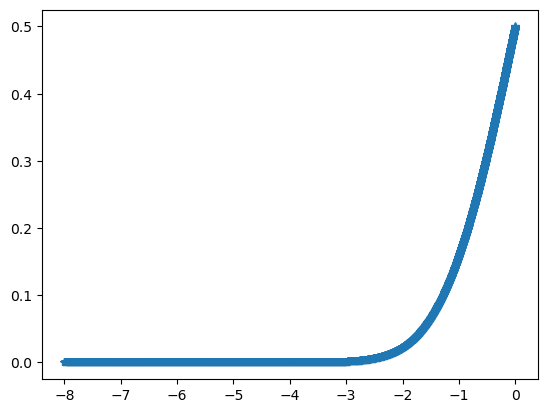

In [93]:
# Remove probabilities
x_eff, y_eff = compress_symmetric(quantiles, probabilities, tolerance=np.finfo(float).eps)
plt.figure()
#plt.plot(quantiles, probabilities, '*-')
plt.plot(x_eff, y_eff, '*-')
plt.show()
plt.close()

In [96]:
print(len(x_eff))
# Save quantiles and probabilities as a JS file
with open("./src/functions/util/normal-cdf-data.js", "w") as file:
    lines = format_variable("X", y_eff)
    lines += format_variable("Y", x_eff)
    lines += "module.exports = { X, Y };"
    file.write(lines)

4096


### Computation of k, for a given threshold to approximate poisson distribution with normal distribution

In [ ]:
import math
from scipy.stats import poisson, norm

epsilon = 1e-16  # Umbral para KL

def poisson_pmf(lambda_, k):
    """Probabilidad de Poisson."""
    fact = math.factorial(int(k))
    return np.power(lambda_,k) * math.exp(-lambda_) / fact

def normal_pdf(mean, std, k):
    """Densidad de la distribución Normal."""
    return (1.0 / (std * math.sqrt(2.0 * math.pi))) * math.exp(-(np.square(k - mean)) / (2 * np.square(std)))

def kl_divergence_poisson_normal(lambda_):
    """Calcula la divergencia KL entre Poisson y Normal para un rango de k."""
    mean = lambda_
    std = math.sqrt(lambda_)
    kl = 0.0
    k = 0.0

    while True:
        pk = poisson_pmf(lambda_, k)
        qk = normal_pdf(mean, std, k)
        k += 1.0

        if pk > epsilon and qk > epsilon:  # Evitar log(0) o divisiones por cero
            kl += pk * math.log(pk / qk)
        else:
            break
    
    return kl

def find_lambda_for_epsilon(tol):
    """Encuentra el valor de lambda para el cual KL(P||Q) <= epsilon."""
    low, high = 1.0, 1000.0  # Rango inicial de búsqueda
    best_lambda = None
    
    while high - low > tol:
        mid = (low + high) / 2.0
        kl = kl_divergence_poisson_normal(mid)
        print(low, mid, high, high-low, kl)
        
        if kl <= epsilon:
            best_lambda = mid
            high = mid  # Seguir buscando un lambda menor que cumpla
        else:
            low = mid  # Aumentar el rango de búsqueda
    
    return best_lambda

lambda_approx = find_lambda_for_epsilon(0.1)
print(f"El valor de lambda para KL <= {epsilon} es: {lambda_approx:.4f}")


### Computation of k, for a given threshold to approximate chi2 distribution with normal distribution

In [ ]:
import numpy as np
from scipy.stats import chi2, norm
from scipy.special import rel_entr

def kl_divergence_chi2_normal(k, num_points=1000000):
    chi2_dist = chi2(k)
    normal_dist = norm(loc=k, scale=np.sqrt(2.0 * k))
    
    x = np.linspace(chi2.ppf(epsilon, k), chi2.ppf(1.0-epsilon, k), num_points)
    
    p = chi2_dist.pdf(x)
    q = normal_dist.pdf(x)
    
    return rel_entr(p, q).sum()

def find_k_for_epsilon(tol=epsilon):
    low, high = 1, 10000000
    best_k = None
    
    while high - low > tol:
        mid = (low + high) / 2
        kl = kl_divergence_chi2_normal(mid)
        print(low, high, best_k, kl)
        
        if kl <= epsilon:
            best_k = mid
            high = mid 
        else:
            low = mid 
    
    return best_k

epsilon=1e-2
k_approx = find_k_for_epsilon(epsilon)
print(k_approx)
print(f"El valor de k para KL <= {epsilon} es: {k_approx:.6f}")
